In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [34]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=200, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError("auto", "mean_absolute_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=1000,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [35]:
INPUTDIM = (2,)
OUTPUTDIM = (2,)

#Training data set

input_train=np.load('../data/input_train.npy')[:8000,:]
input_test=np.load('../data/input_test.npy')[:2000,:]
output_train=np.load('../data/output_train.npy')[:8000,:]
output_test=np.load('../data/output_test.npy')[:2000,:]

In [36]:
input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

# x = layers.LSTM(32, return_sequences=True, name = 'blstm1')(input_layer)

# x_encoder = layers.Bidirectional(layers.LSTM(32), name = 'blstm2')(input_layer)

# input_dec = tf.expand_dims(tf.ones((INPUTDIM[0],1)),0)

# x = layers.LSTM(OUTPUTDIM[1], return_sequences=True, name = 'lstm', activation=None)(input_dec, initial_state=x_encoder)

x = layers.Dense(64, activation='elu',kernel_regularizer = regularizers.l2(0.00)) (input_layer)

x = layers.Dense(64, activation='elu',kernel_regularizer = regularizers.l2(0.00)) (x)

x = layers.Dense(OUTPUTDIM[0] , activation='elu',kernel_regularizer = regularizers.l2(0.00))(x)

model = tf.keras.Model(inputs=input_layer, outputs = x, name ='model')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 dense_14 (Dense)            (None, 64)                192       
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=["mean_absolute_error"]
            )

In [38]:
history = model.fit(
            input_train, output_train,
            epochs=1000,
            validation_data=(input_test, output_test),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=50, min_delta=0.0001, restore_best_weights=True, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', patience=5, mode='auto', verbose=1, factor=0.01, min_lr=1e-12)
                ]
            )

Epoch 1/1000
250/250 [==============================] - 2s 4ms/step - loss: 0.1142 - mean_absolute_error: 0.1850 - val_loss: 0.0017 - val_mean_absolute_error: 0.0058 - lr: 1.0000e-04
Epoch 2/1000
250/250 [==============================] - 1s 3ms/step - loss: 7.4287e-04 - mean_absolute_error: 0.0031 - val_loss: 0.0014 - val_mean_absolute_error: 0.0052 - lr: 1.0000e-04
Epoch 3/1000
250/250 [==============================] - 1s 3ms/step - loss: 6.1382e-04 - mean_absolute_error: 0.0029 - val_loss: 0.0012 - val_mean_absolute_error: 0.0045 - lr: 1.0000e-04
Epoch 4/1000
250/250 [==============================] - 1s 3ms/step - loss: 4.8384e-04 - mean_absolute_error: 0.0026 - val_loss: 8.8397e-04 - val_mean_absolute_error: 0.0040 - lr: 1.0000e-04
Epoch 5/1000
250/250 [==============================] - 1s 3ms/step - loss: 3.6671e-04 - mean_absolute_error: 0.0022 - val_loss: 6.4712e-04 - val_mean_absolute_error: 0.0048 - lr: 1.0000e-04
Epoch 6/1000
250/250 [==============================] - 1s 3m

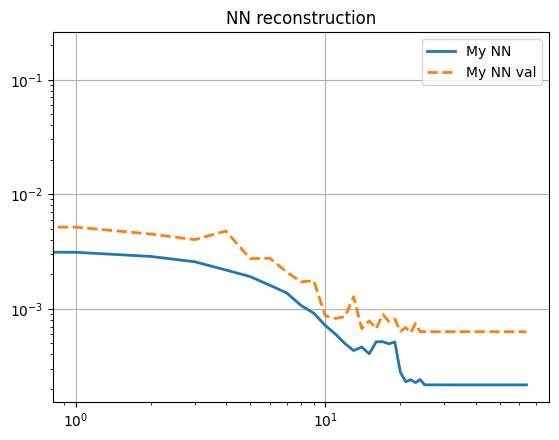

In [39]:
bc     = history.history['mean_absolute_error']
val_bc = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)
#plt.show(block=False)

plt.legend(('My NN','My NN val'))
plt.show()

63/63 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Prey [-]')

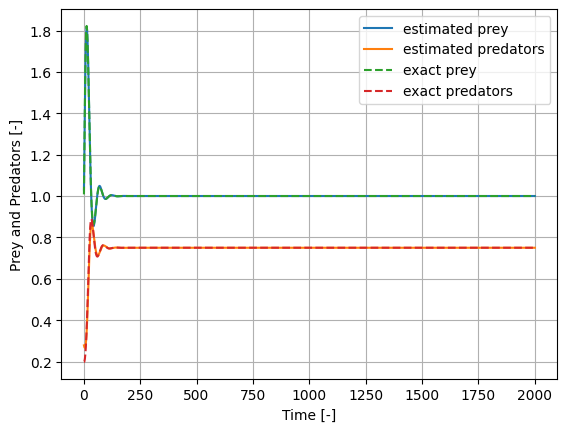

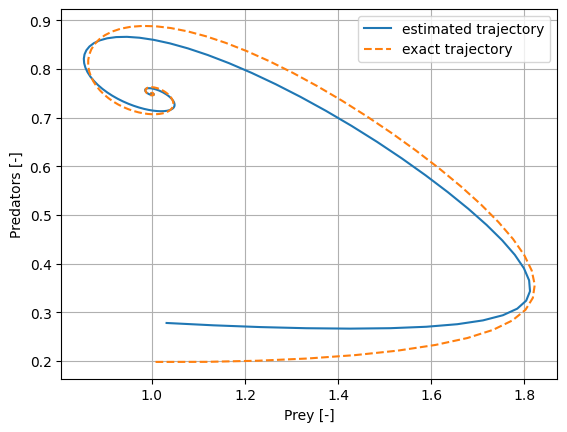

In [40]:
rec_output = model.predict(input_test)
index = 0
T = 50*40
Nt = 50*40
dt = T/Nt
tt=np.arange(dt,T+dt,dt)

plt.figure()
plt.grid(True)
plt.plot(tt,rec_output[T*index:T*(index+1),0], label='estimated prey')
plt.plot(tt,rec_output[T*index:T*(index+1),1], label='estimated predators')
plt.plot(tt,output_test[T*index:T*(index+1),0], label='exact prey', linestyle='--')
plt.plot(tt,output_test[T*index:T*(index+1),1], label='exact predators', linestyle='--')
plt.legend()
plt.ylabel('Prey and Predators [-]')
plt.xlabel('Time [-]')

plt.figure()
plt.grid(True)
plt.plot(rec_output[T*index:T*(index+1),0],rec_output[T*index:T*(index+1),1], label='estimated trajectory')
plt.plot(output_test[T*index:T*(index+1),0],output_test[T*index:T*(index+1),1], label='exact trajectory', linestyle='--')
plt.legend()
plt.ylabel('Predators [-]')
plt.xlabel('Prey [-]')
# plt.xlim([0,max(np.amax(rec_output[T*index:T*(index+1),0]),np.amax(output_test[T*index:T*(index+1),0]))])
# plt.ylim([0,max(np.amax(rec_output[T*index:T*(index+1),1]),np.amax(output_test[T*index:T*(index+1),1]))])

In [43]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/model_NN.h5')
    print('NN saved')

NN saved
